The communities present at iter no.0:-
 is[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]
The communities present at iter no.1:-
 is[[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]]
The communities present at iter no.2:-
 is[[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [5, 6, 10, 16], [0, 1, 2, 3, 4, 7, 11, 12, 13, 17, 19, 21]]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15336\3243920447.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('inferno', len(community_history[-1]))


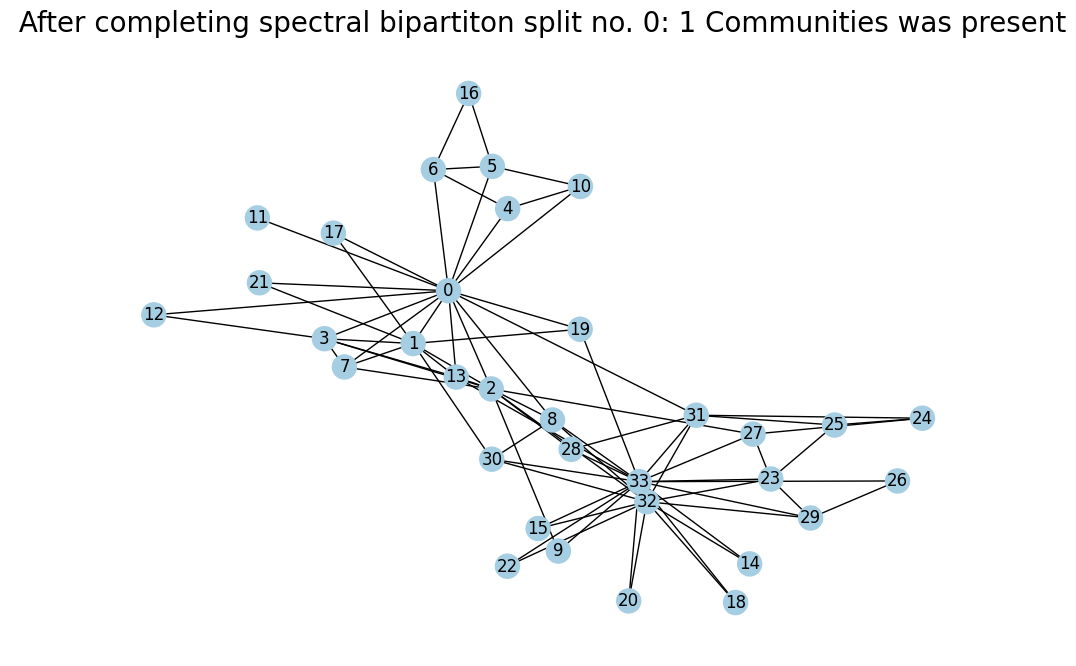

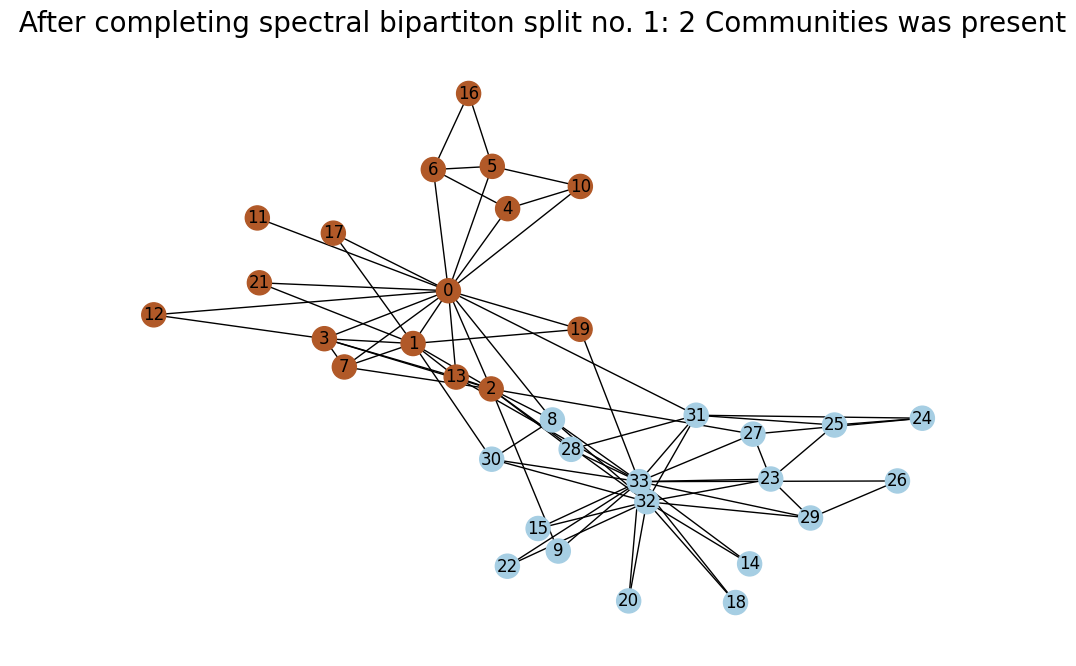

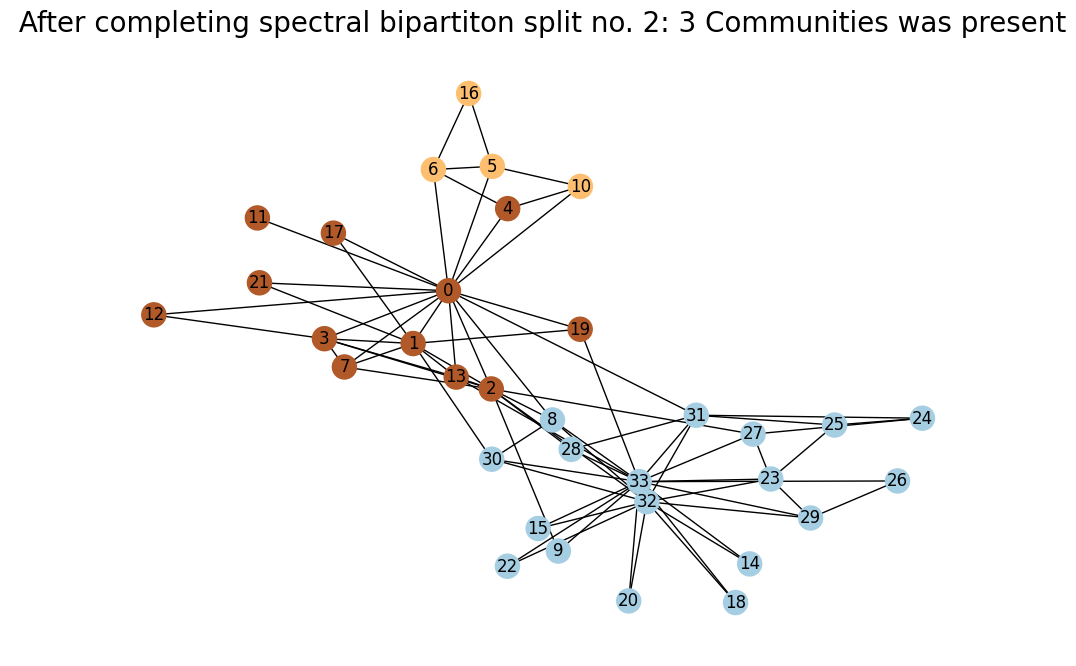

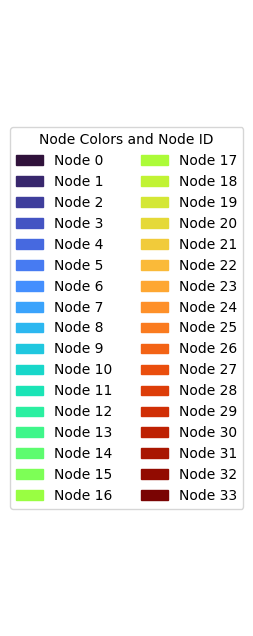

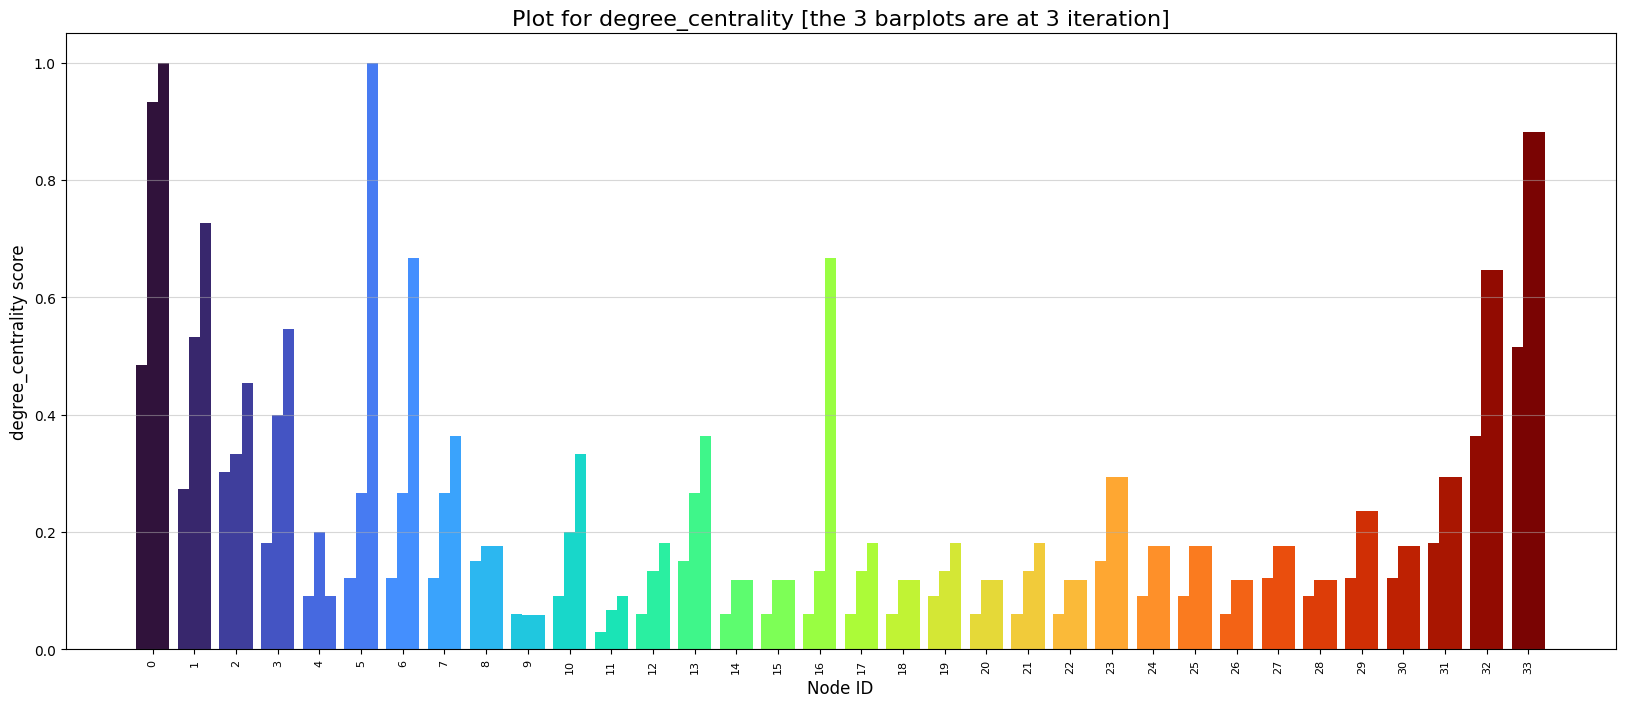

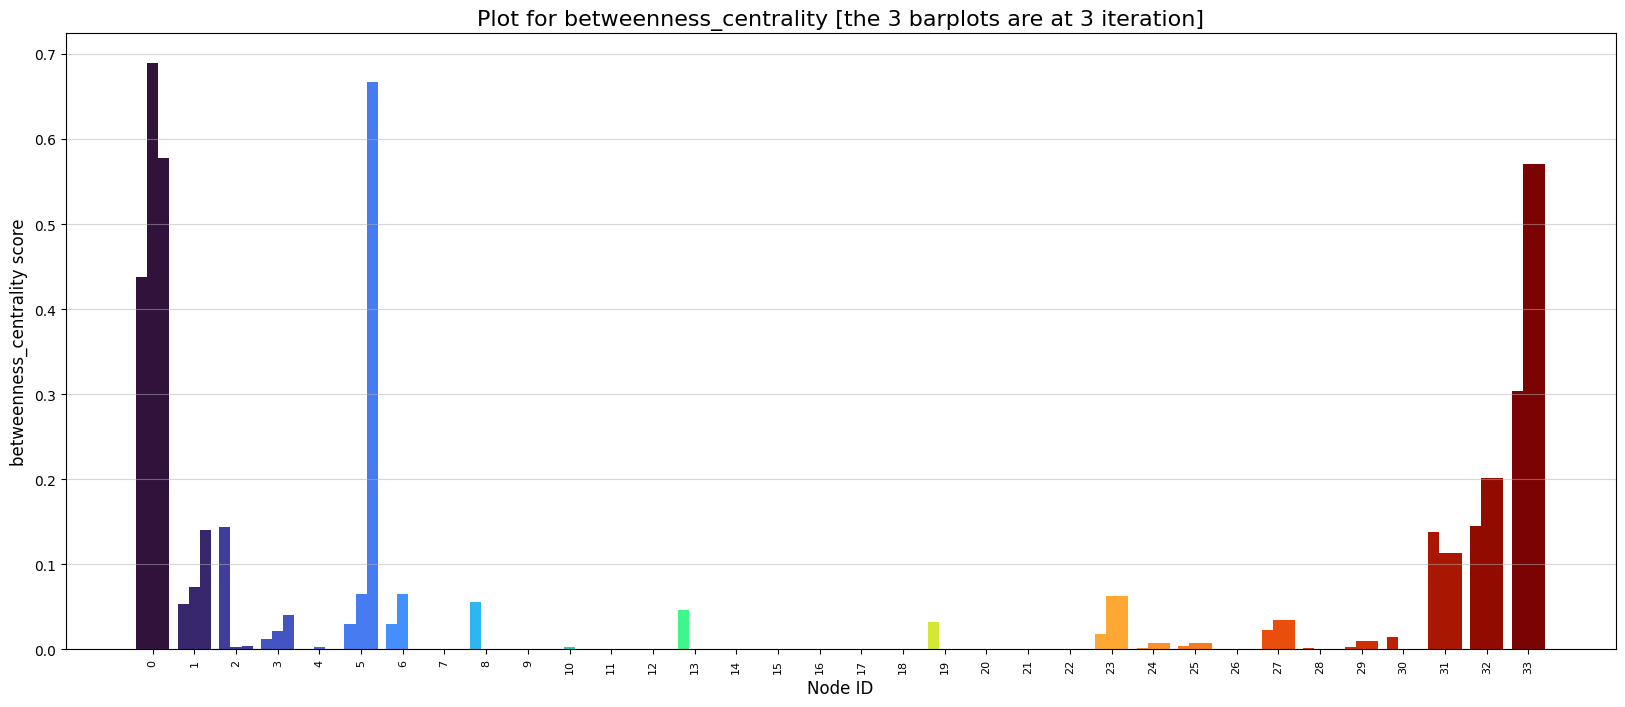

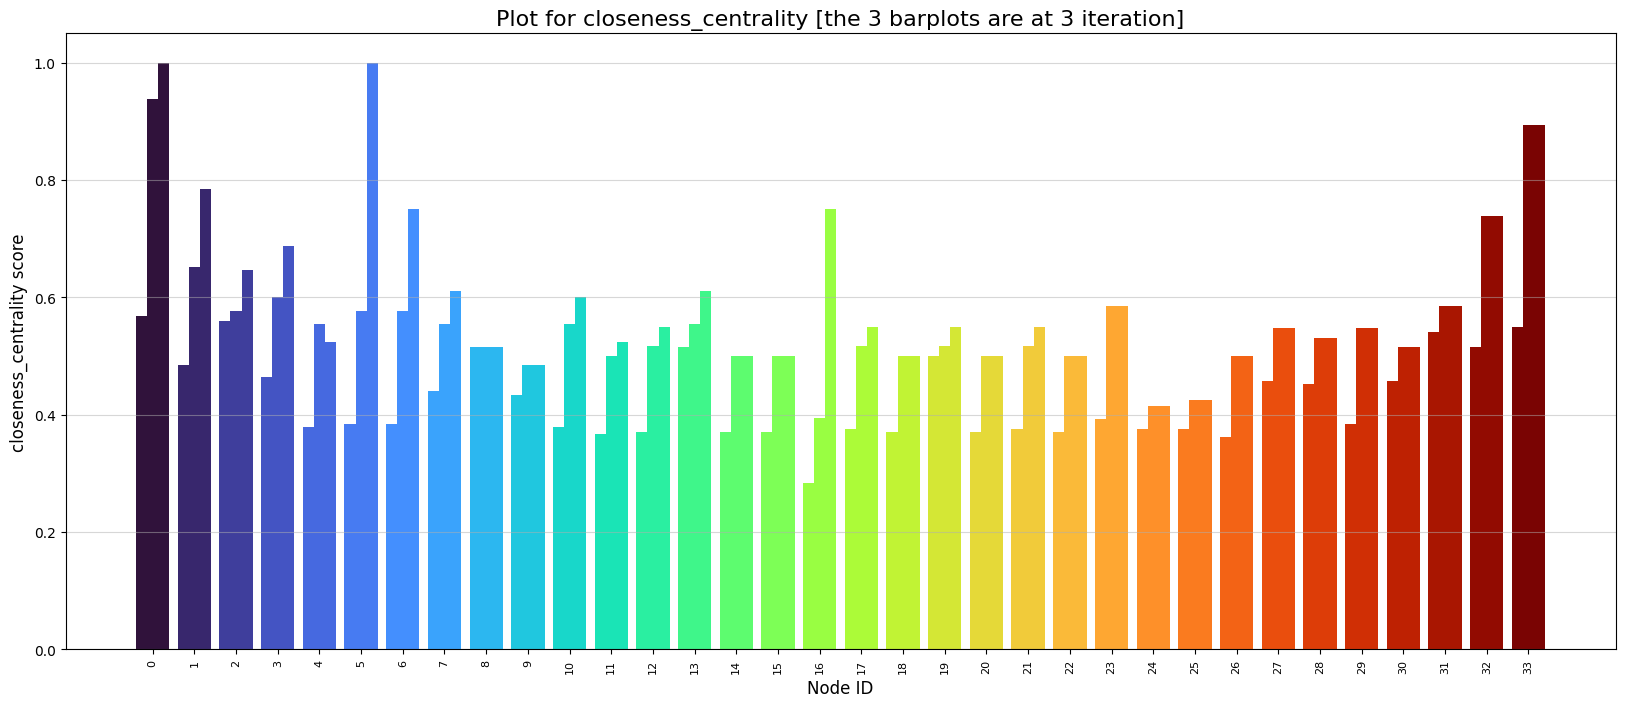

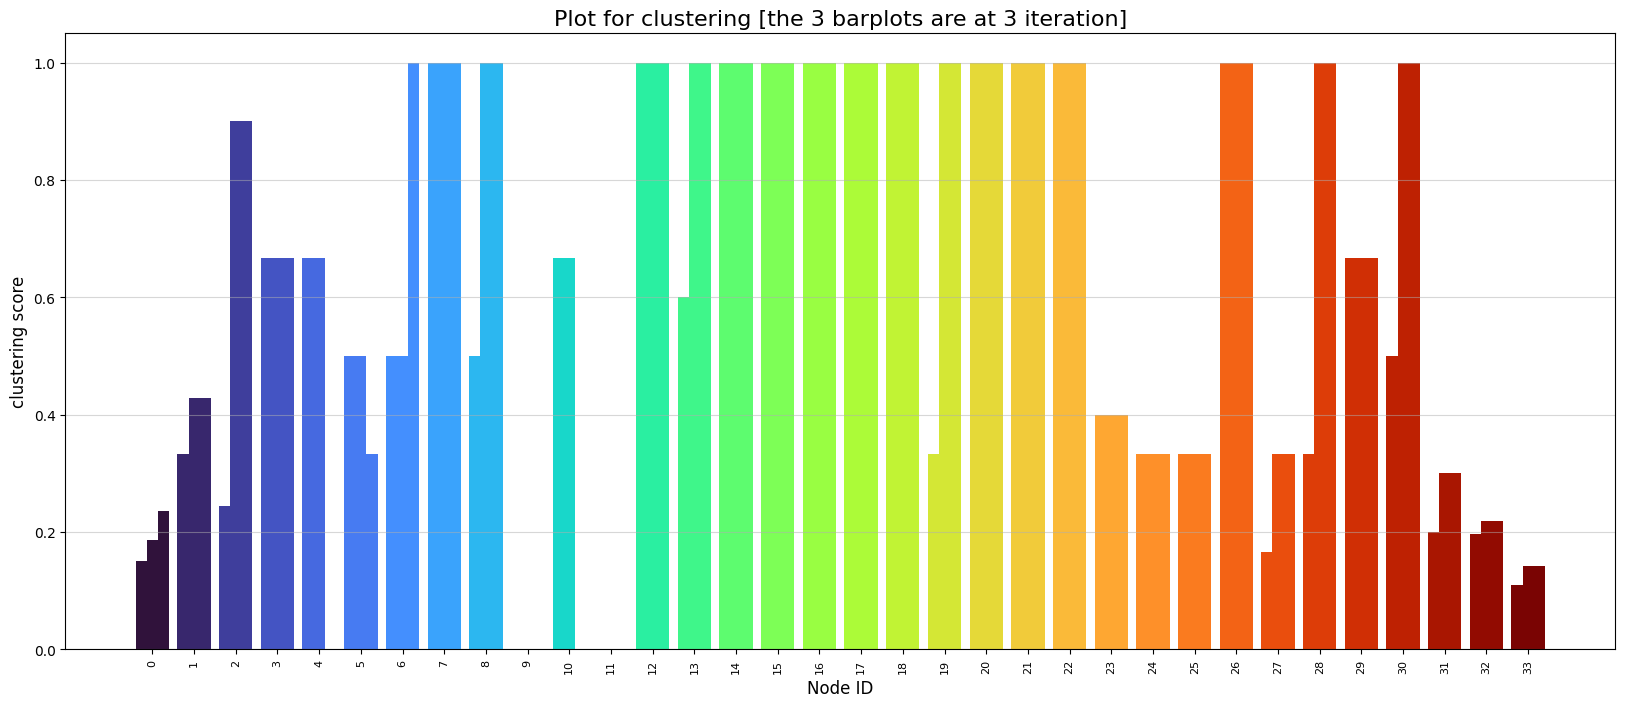

In [64]:
import networkx as nx
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
from collections import defaultdict 
import matplotlib.patches as mp
import matplotlib.cm as cm
G = nx.karate_club_graph()
n = G.number_of_nodes()
m = G.number_of_edges()
k_total = dict(G.degree())



def spectral_bipartition_algrthm(nodes, G):

    community_history = []                      # initialising community history list
    communities = [list(nodes)]       

    community_history.append([c.copy() for c in communities])   # initially community history has whole graph

    while True:

        new_communities = []       #used to add communities formed at next split iteration to community history 
        split_happened = False   #used to check if split has happen and if it has happen to exit the while loop to stop as it can  no longer be split

        for community in communities:

            if len(community) <= 1:
                new_communities.append(community)
                continue
            subgraph_nodes = list(community)
            A_sub = nx.to_numpy_array(G, nodelist=subgraph_nodes)
            m_sub = G.subgraph(community).number_of_edges()
            k_sub_vec = np.array([G.subgraph(subgraph_nodes).degree(n) for n in subgraph_nodes])
    
            k_sub_vec_Transpose_2d = k_sub_vec.reshape(len(subgraph_nodes), 1)
            k_sub_vec_2d = k_sub_vec.reshape(1, len(subgraph_nodes))

            

            exp_edges = (k_sub_vec_Transpose_2d @ k_sub_vec_2d) / (2 * m_sub)
            B_sub = A_sub - exp_edges

            eigenvalues, eigenvectors = np.linalg.eigh(B_sub)
            max_eigenvector = eigenvectors[:, -1]
            max_eigenvalue = eigenvalues[-1]
            

            if max_eigenvalue <= 0:
                new_communities.append(community)
                continue #if this continue statement is executed then it will skip rest of code so split_happend will not be assigned True.
                         #Then it will go too break and exit while loop
            
            
            comm_pos = [node for  node in subgraph_nodes if max_eigenvector[subgraph_nodes.index(node)] > 0]
            comm_neg = [node for  node in subgraph_nodes if max_eigenvector[subgraph_nodes.index(node)] <= 0]

            
            if len(comm_pos)==0 or len(comm_neg)==0:
                new_communities.append(community)
                continue

            
            new_communities.append(comm_pos)
            new_communities.append(comm_neg)
            split_happened = True

        if not split_happened:
            break

        communities = new_communities
        community_history.append([c for c in new_communities]) #Used to create a nested list

    return community_history




community_history=spectral_bipartition_algrthm(list(G.nodes()),G)
for i,j in enumerate(community_history):
    print(f"The communities present at iter no.{i}:-\n is{j}")
colors = plt.cm.get_cmap('inferno', len(community_history[-1]))
pos = nx.spring_layout(G, seed=42)
for i, communities in enumerate(community_history):
    plt.figure(figsize=(12, 8))
    plt.title(f" After completing spectral bipartiton split no. {i}: {len(communities)} Communities was present", fontsize=20)
    
    
    node_colors = [0] * n
    for comm_idx, community in enumerate(communities):
        for node in community:
            node_colors[node] = comm_idx
   
    nx.draw(G, pos, with_labels=True,node_color=node_colors, cmap=plt.cm.Paired, edge_color='black')
    plt.show()

metrics_history = {}
metrics_initalgraph = {
    'degree_centrality': nx.degree_centrality(G),
    'betweenness_centrality': nx.betweenness_centrality(G),
    'closeness_centrality': nx.closeness_centrality(G),
    'clustering': nx.clustering(G)
}
metrics_history[0] = metrics_initalgraph
for iteration in range(1,len(community_history)):
    metrics_iter = {'degree_centrality': {}, 'betweenness_centrality': {},'closeness_centrality': {}, 'clustering': {}}
    for community in community_history[iteration]:
        subgraph = G.subgraph(community)
        metrics_iter['degree_centrality'].update(nx.degree_centrality(subgraph))
        metrics_iter['betweenness_centrality'].update(nx.betweenness_centrality(subgraph, normalized=True))
        metrics_iter['closeness_centrality'].update(nx.closeness_centrality(subgraph))
        metrics_iter['clustering'].update(nx.clustering(subgraph))
    metrics_history[iteration] = metrics_iter
metrics_to_plot = ['degree_centrality','betweenness_centrality','closeness_centrality','clustering']

all_nodes = sorted(list(G.nodes()))
num_nodes = len(all_nodes)
iters = sorted(metrics_history.keys())
num_iter = len(iters)
node_colors = cm.turbo(np.linspace(0, 1, num_nodes))
x_ticks = np.arange(len(all_nodes))
group_width = 0.8
bar_width = group_width / num_iter

legend_handles = []
for i, node_id in enumerate(all_nodes):
    patch = mp.Patch(color=node_colors[i], label=f'Node {node_id}')
    legend_handles.append(patch)


fig_legend, ax_legend = plt.subplots(figsize=(3, 8))

ax_legend.legend(handles=legend_handles, loc='center', ncol=2, title="Node Colors and Node ID")


ax_legend.axis('off')


plt.show()

for metric_name in metrics_to_plot:
    
    
    node_histories = defaultdict(list)#Used for creating a dictionary with list centrality scores as value and each node as key
    for iter_num in iters:
        for node_id in all_nodes:
            value = metrics_history[iter_num][metric_name].get(node_id, 0)
            node_histories[node_id].append(value)#Associated with each key 'NODE' is its list of centrality scores 
    
    
    plt.figure(figsize=(20, 8))

    
    for i, iter_num in enumerate(iters):
        bar_positions = x_ticks - (group_width / 2) + (i * bar_width) + (bar_width / 2)
        values = [node_histories[node_id][i] for node_id in all_nodes]
        plt.bar(bar_positions, values, width=bar_width, color=node_colors,edgecolor='black',linewidth=.7)

    
    
    plt.title(f'Plot for {metric_name} [{len(node_histories[0])} barplots at each node are its metric scores at {len(node_histories[0])} different iteration]', fontsize=16)
    plt.xlabel("Node ID", fontsize=12)
    plt.ylabel(f"{metric_name} score", fontsize=12)
    plt.xticks(x_ticks, labels=all_nodes, rotation=90, fontsize=8)
    plt.grid(True, axis='y', linestyle='-', alpha=0.5)
    
    
    plt.show()



